In [1]:
import os
os.chdir('..')

In [2]:
# Get the results for each mz
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json



In [3]:
mzs = [1, 2, 5, 10]
results_gkf0 = {'valid': {}, 'test': {}}
for mz in mzs:
    results_gkf0['valid'][mz] = {}
    results_gkf0['test'][mz] = {}
    path = f'results/multi/mz{mz}/rt10/ms2/200spd/thr0.0/all/' \
        f'b14-b13-b12-b11-b10-b9-b8-b7-b6-b5-b4-b3-b2-b1_binary0_-1_gkf0_ovr0_mz0-10000rt0-320_na_h/' \
        f'xgboost/saved_models/best_params_inputs_xgboost_values.json'
    values = json.load(open(path, 'r'))
    for key, value in values.items():
        if 'train' in key:
            continue
        group, key = key.split('_')
        results_gkf0[group][mz][key] = value

# remove acc from results
for mz in mzs:
    for group in ['valid', 'test']:
        results_gkf0[group][mz].pop('acc')

results_gkf1 = {'valid': {}, 'test': {}}
for mz in mzs:
    results_gkf1['valid'][mz] = {}
    results_gkf1['test'][mz] = {}
    path = f'results/multi/mz{mz}/rt10/ms2/200spd/thr0.0/all/b14-b13-b12-b11-b10-b9-b8-b7-b6-b5-b4-b3-b2-b1_binary0_-1_gkf1_ovr0_mz0-10000rt0-320_na_h/xgboost/saved_models/best_params_inputs_xgboost_values.json'
    values = json.load(open(path, 'r'))
    for key, value in values.items():
        if 'train' in key:
            continue
        group, key = key.split('_')
        results_gkf1[group][mz][key] = value

# remove acc from results
for mz in mzs:
    for group in ['valid', 'test']:
        results_gkf1[group][mz].pop('acc')

# Concatenate the results
results = pd.concat([
    pd.DataFrame(results_gkf0['valid']).T,
    pd.DataFrame(results_gkf1['valid']).T,
    pd.DataFrame(results_gkf0['test']).T,
    pd.DataFrame(results_gkf1['test']).T,
])

# Add a new column for the group
results['group'] = ['valid'] * len(mzs) + ['valid'] * len(mzs) + ['test'] * len(mzs) + ['test'] * len(mzs)
results['gkf'] = ['gkf0'] * len(mzs) + ['gkf1'] * len(mzs) + ['gkf0'] * len(mzs) + ['gkf1'] * len(mzs)

# Use the index as the mz_bin
results['mz_bin'] = results.index
# reset index
results = results.reset_index(drop=True)
results

,mcc,group,gkf,mz_bin
0,"[0.902951633678539, 0.8932777977508743, 0.8966...",valid,gkf0,1
1,"[0.8931338628478286, 0.8969973514778989, 0.893...",valid,gkf0,2
2,"[0.8610564159236314, 0.8348698963554408, 0.845...",valid,gkf0,5
3,"[0.8387436112092475, 0.8254390143178889, 0.841...",valid,gkf0,10
4,"[0.8776820057820397, 0.8798300509777417, 0.710...",valid,gkf1,1
5,"[0.8776820057820397, 0.8798300509777417, 0.710...",valid,gkf1,2
6,"[0.7659201678997798, 0.7799778182115312, 0.661...",valid,gkf1,5
7,"[0.7579879211936126, 0.5582582853122595, 0.776...",valid,gkf1,10
8,"[0.9191934604125284, 0.8934490271430606, 0.899...",test,gkf0,1
9,"[0.896678433037107, 0.8835013581551404, 0.9063...",test,gkf0,2


In [4]:
# Each item of the list in mcc column should be its own row. reindex
results = results.explode('mcc')
results

,mcc,group,gkf,mz_bin
0,0.902952,valid,gkf0,1
0,0.893278,valid,gkf0,1
0,0.896624,valid,gkf0,1
0,0.893348,valid,gkf0,1
0,0.899766,valid,gkf0,1
...,...,...,...,...
15,0.746201,test,gkf1,10
15,0.65026,test,gkf1,10
15,0.708002,test,gkf1,10
15,0.670846,test,gkf1,10


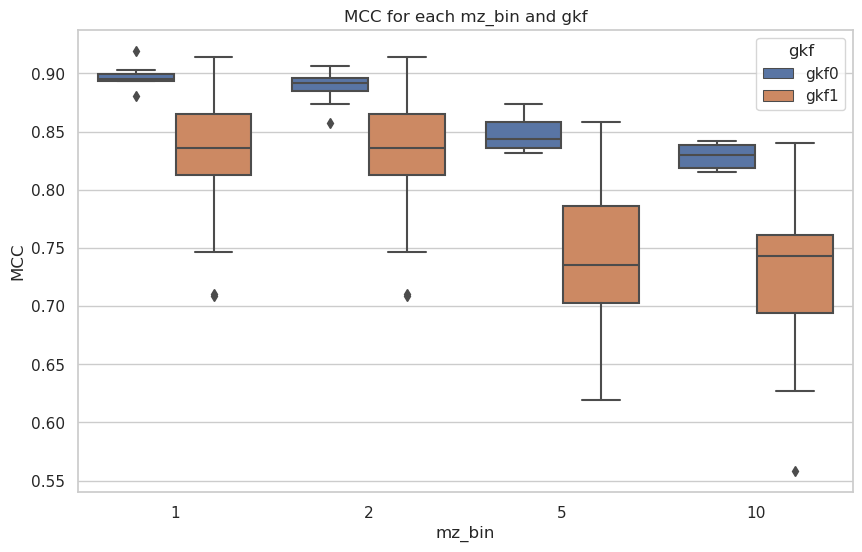

In [5]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='mz_bin', y='mcc', hue='gkf', data=results)
plt.title('MCC for each mz_bin and gkf')
plt.xlabel('mz_bin')
plt.ylabel('MCC')
plt.show()

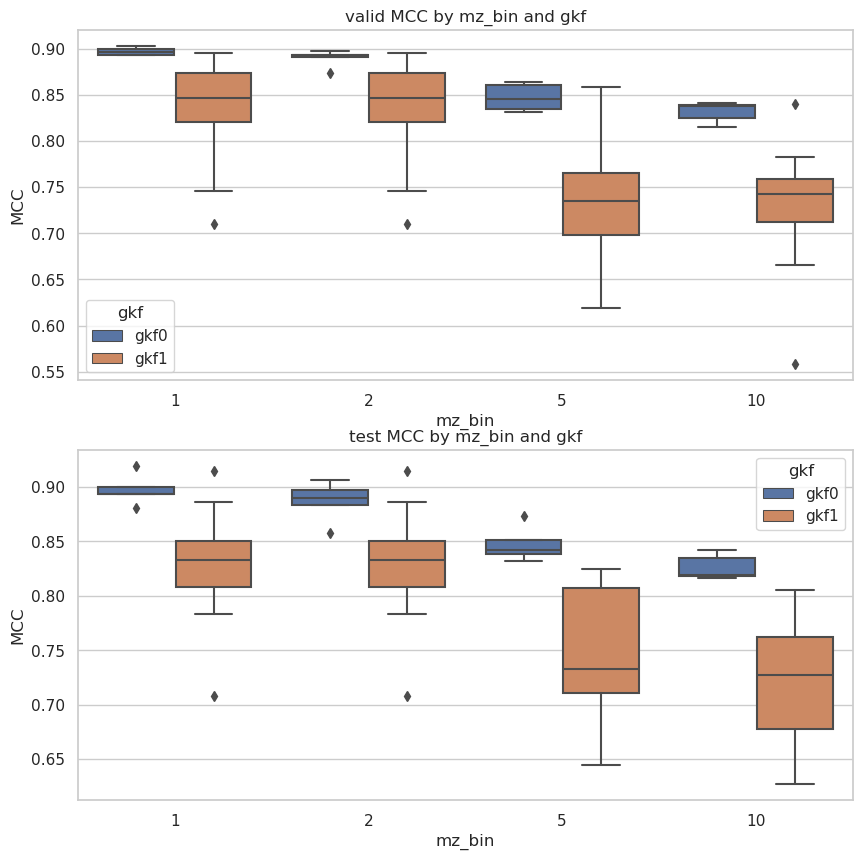

In [6]:
# Make boxplots comparing the mccs for each mz_bin and gkf
# Make a plot for valid and another for test
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
for i, group in enumerate(['valid', 'test']):
    sns.boxplot(
        x='mz_bin',
        y='mcc',
        hue='gkf',
        data=results[results['group'] == group],
        ax=axs[i]
    )
    axs[i].set_title(f'{group} MCC by mz_bin and gkf')
    axs[i].set_xlabel('mz_bin')
    axs[i].set_ylabel('MCC')

In [7]:
# for group in ['valid', 'test']:
#     # Modify the dataframe to make a row per score in the column value, which contains a list
#     df = pd.DataFrame(results[group])
#     df = df.T
#     df = df.reset_index()
#     df = df.melt(id_vars='index', var_name='metric', value_name='value')
#     # Split the list in the value column
#     df = df.explode('value')
#     # Make a boxplot
#     plt.figure(figsize=(8, 6))
#     sns.boxplot(data=df, x='index', y='value', hue='metric')
#     plt.xlabel('mz')
#     plt.ylabel('Score')
#     plt.title(f'{group} score for different mz values')
#     plt.show()



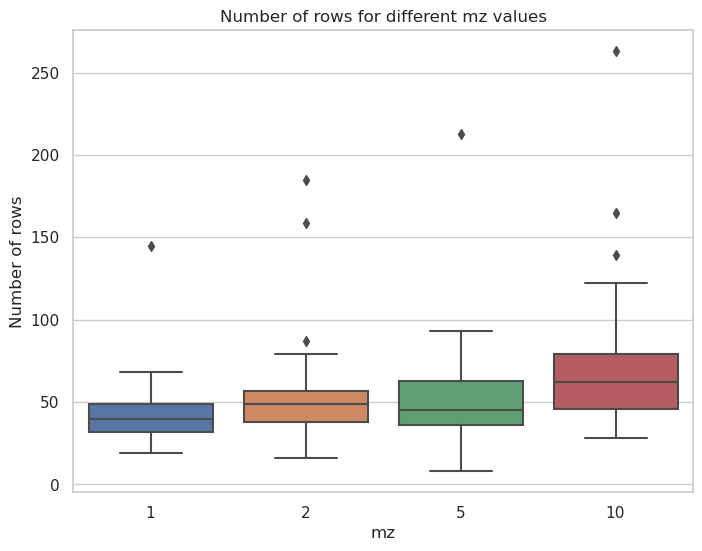

In [8]:
n_rows_dict = {}
for mz_bin in [1, 2, 5, 10]:
    rt_bin = 10
    group = 'valid'
    gkf = 0
    exp_name = f'b14-b13-b12-b11-b10-b9-b8-b7-b6-b5-b4-b3-b2-b1_binary0_-1_gkf{gkf}_ovr0_mz0-10000rt0-320_na_h'
    path =  f'/home/simon/MSML3/results/multi/mz{mz_bin}/rt{rt_bin}/ms2/200spd/thr0.0/all/' \
            f'{exp_name}/xgboost/'

    dfs = {}
    for group in ['valid', 'test']:
        # Get all csvs in the directory that ends with abs.csv
        csvs = os.listdir(path)
        csvs = [csv for csv in csvs if csv.endswith('abs.csv')]
        # Read the csvs into a list of dataframes
        dfs[group] = {csv.split('_')[3]: pd.read_csv(path + csv, index_col=0) for csv in csvs if csv.split('_')[0] == group}
        # Concatenate the dataframes
        # Remove rows at value 0
        for c in list(dfs[group].keys()):
            dfs[group][c] = dfs[group][c].iloc[:,0][dfs[group][c].iloc[:,0] != 0]
    names = list(dfs['valid'].keys())
    # Count the number of rows in each dataframe
    n_rows_dict[mz_bin] = [len(df) for df in dfs['valid'].values()]

new_df = pd.DataFrame.from_dict(n_rows_dict, orient='index')
# Make boxplots
plt.figure(figsize=(8, 6))
sns.boxplot(data=new_df.T)
plt.xlabel('mz')
plt.ylabel('Number of rows')
plt.title('Number of rows for different mz values')
plt.show()


# Differences in processing times

In [14]:
def analyze_processing_time(directory, file_type='raw'):
    if file_type == 'raw':
        df = pd.read_csv(f'{directory}/processing_times_raw.log')
        # Remove rows with missing values
        df = df.dropna()
        # Drop rows with processing time less than 0
        df = df[df['duration(s)'] >= 0]

        total_processing_time = df['duration(s)'].sum()
        avg_processing_time = df['duration(s)'].mean()
        largest_processing_time = df.loc[df['duration(s)'].idxmax()]
        smallest_processing_time = df.loc[df['duration(s)'].idxmin()]
        colname = 'duration(s)'
    elif file_type.__contains__('mzdb'):
        df = pd.read_csv(f'{directory}/{file_type}')
        # Remove rows with missing values
        df = df.dropna()
        # Drop rows with processing time less than 0
        df = df[df['time(s)'] >= 0]

        total_processing_time = df['time(s)'].sum()
        avg_processing_time = df['time(s)'].mean()
        largest_processing_time = df.loc[df['time(s)'].idxmax()]
        smallest_processing_time = df.loc[df['time(s)'].idxmin()]
        colname = 'time(s)'
    elif file_type.__contains__('gkf'):
        df = pd.read_csv(f'{directory}/{file_type}/time.csv')
        # Remove rows with missing values
        df = df.dropna()
        # Drop rows with processing time less than 0
        df = df[df['Time'] >= 0]

        total_processing_time = df['Time'].sum()
        avg_processing_time = df['Time'].mean()
        largest_processing_time = df.loc[df['Time'].idxmax()]
        smallest_processing_time = df.loc[df['Time'].idxmin()]
        colname = 'Time'
    else:
        raise ValueError('Invalid file type. Please choose from: raw, mzdb/200spd, tsv/mz10/rt10/200spd/ms2/all, tsv/mz0.1/rt10/200spd/ms2/all')

    print(f'Total processing time: {total_processing_time:.2f} s')
    print(f'Average processing time: {avg_processing_time:.2f} s')
    print(f'Largest processing time: {largest_processing_time[colname]} ({largest_processing_time[colname]:.2f} s)')
    print(f'Smallest processing time: {smallest_processing_time[colname]} ({smallest_processing_time[colname]:.2f} s)')
    

    # Plot histogram of processing times
    plt.figure(figsize=(5, 3))
    plt.hist(df[colname], bins=50, color='green', edgecolor='black')
    plt.title(f'Histogram of Processing Times for {file_type}')
    plt.xlabel('Processing Time (s)')
    plt.ylabel('Number of Files')
    plt.show()
    plt.close()

    # Plot boxplot of processing times
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=df[colname], color='red')
    plt.title(f'Boxplot of Processing Times for {file_type}')
    plt.xlabel('Processing Time (s)')
    plt.show()
    plt.close()

    return df[colname]



Analyzing mz1 gkf0
Total processing time: 33387.58 s
Average processing time: 155.29 s
Largest processing time: 255.96 (255.96 s)
Smallest processing time: 62.33 (62.33 s)


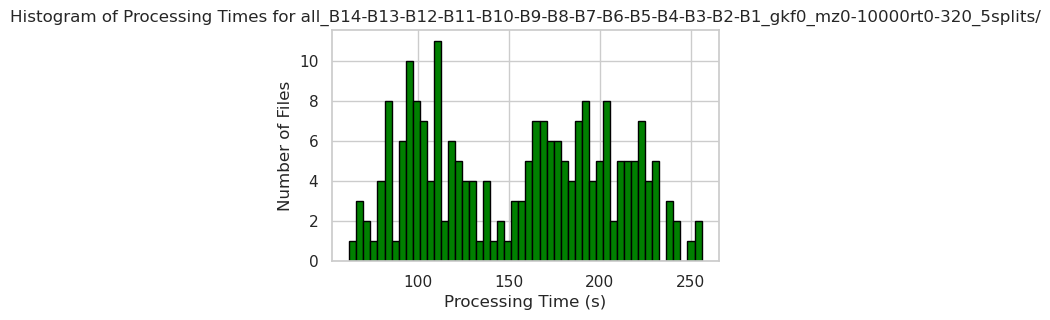

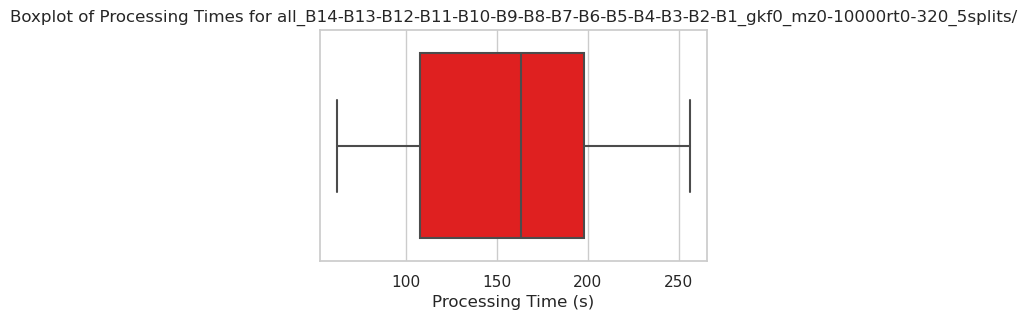

Analyzing mz1 gkf1
Total processing time: 24411.09 s
Average processing time: 113.54 s
Largest processing time: 155.41 (155.41 s)
Smallest processing time: 48.02 (48.02 s)


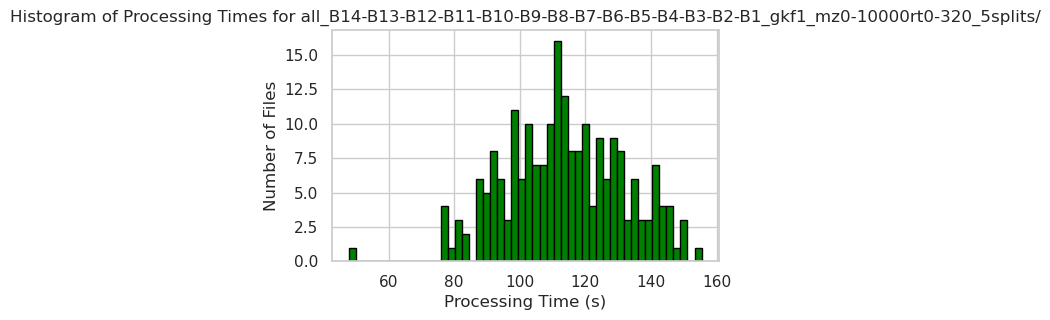

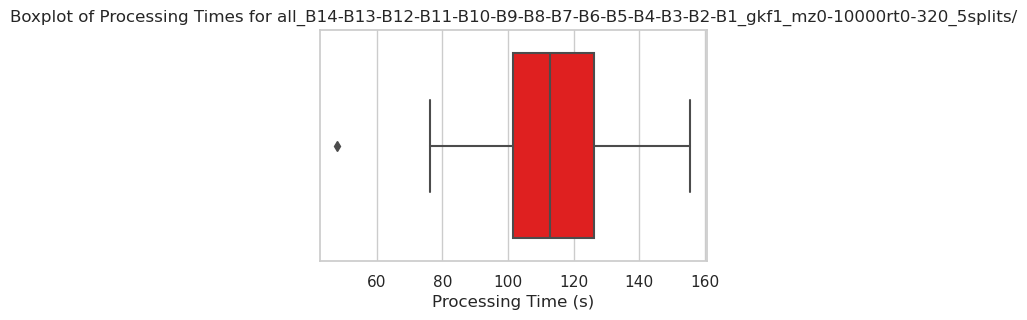

Analyzing mz2 gkf0
Total processing time: 24024.15 s
Average processing time: 111.74 s
Largest processing time: 148.26 (148.26 s)
Smallest processing time: 55.93 (55.93 s)


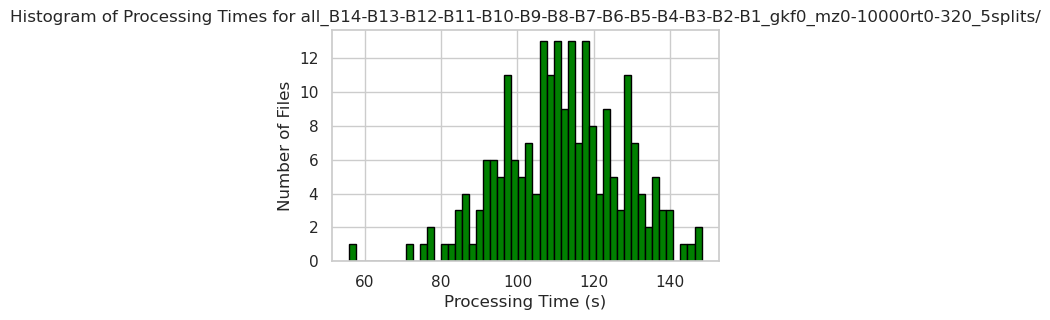

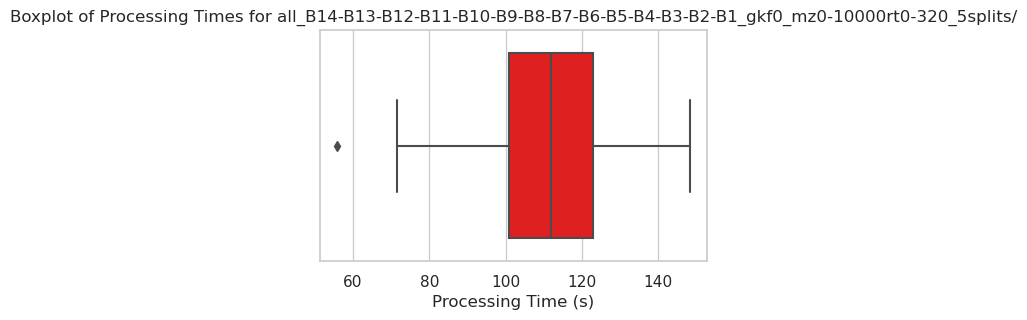

Analyzing mz2 gkf1
Total processing time: 12669.01 s
Average processing time: 58.93 s
Largest processing time: 76.48 (76.48 s)
Smallest processing time: 29.75 (29.75 s)


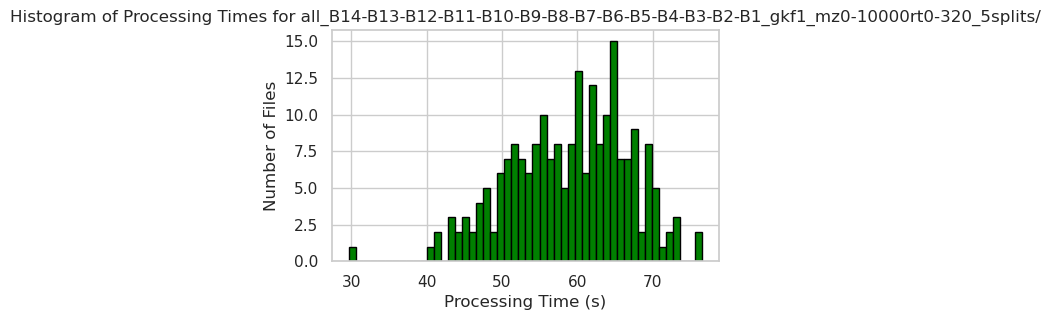

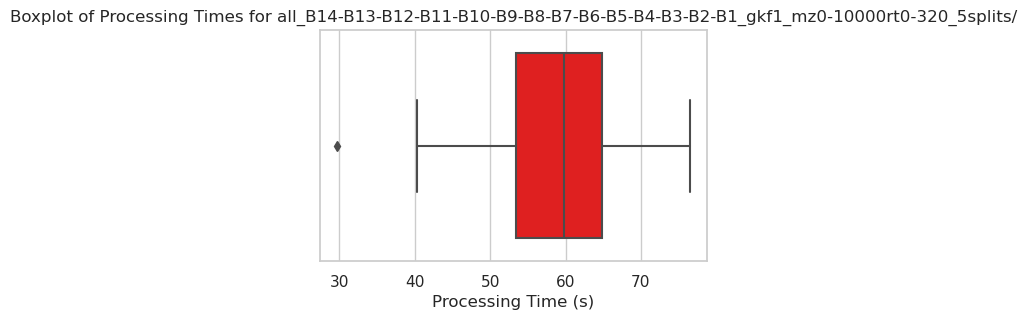

Analyzing mz5 gkf0
Total processing time: 7053.17 s
Average processing time: 32.81 s
Largest processing time: 40.15 (40.15 s)
Smallest processing time: 18.77 (18.77 s)


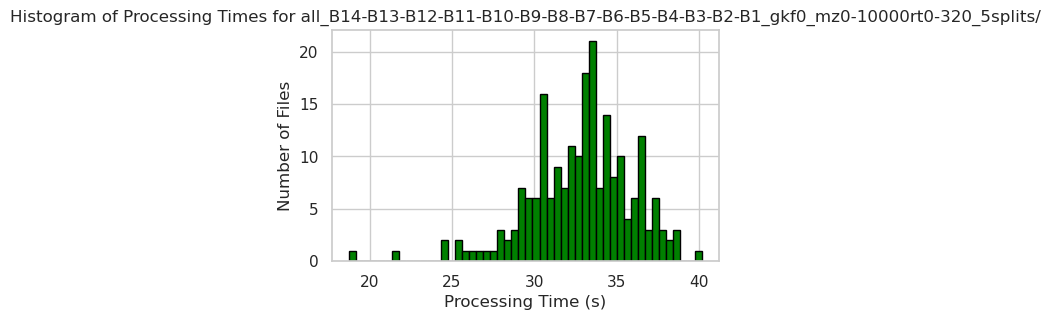

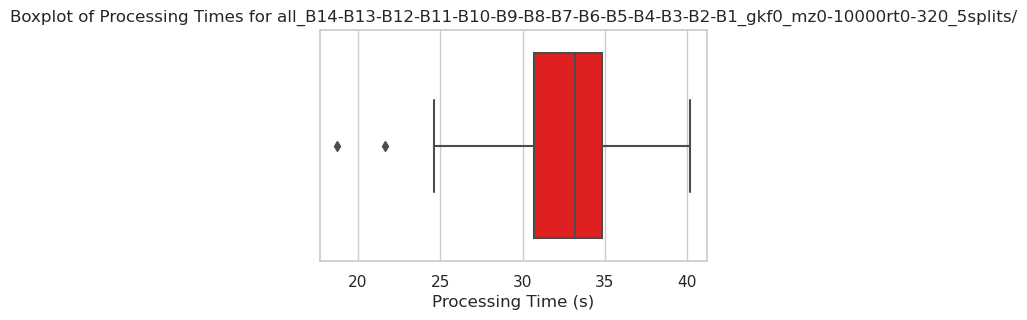

Analyzing mz5 gkf1
Total processing time: 7218.34 s
Average processing time: 33.57 s
Largest processing time: 42.28 (42.28 s)
Smallest processing time: 19.15 (19.15 s)


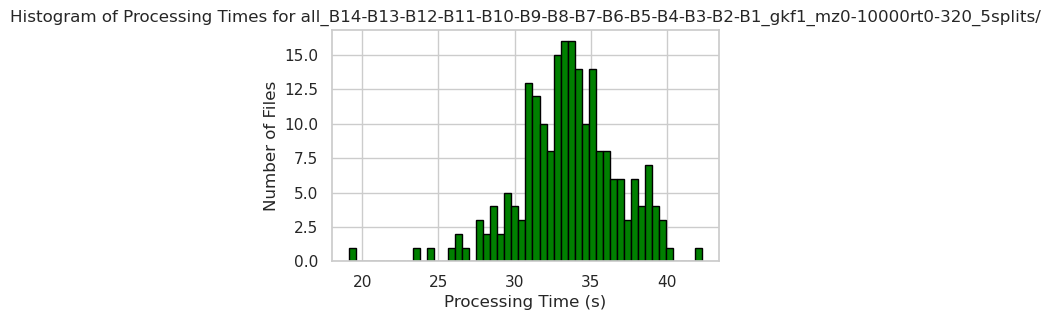

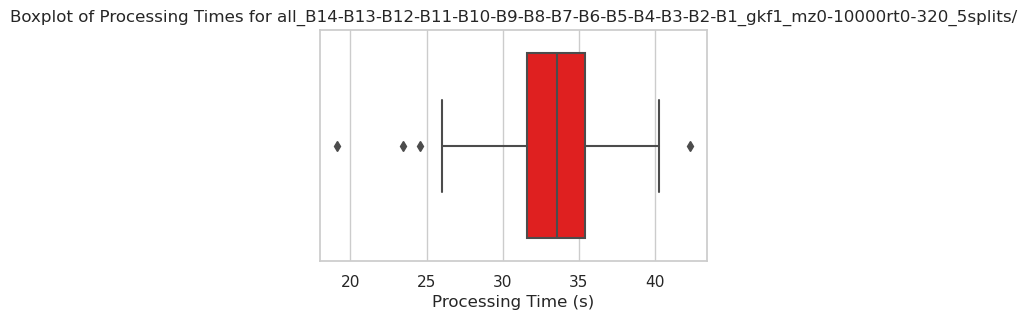

Analyzing mz10 gkf0
Total processing time: 3260.48 s
Average processing time: 15.17 s
Largest processing time: 17.49 (17.49 s)
Smallest processing time: 10.04 (10.04 s)


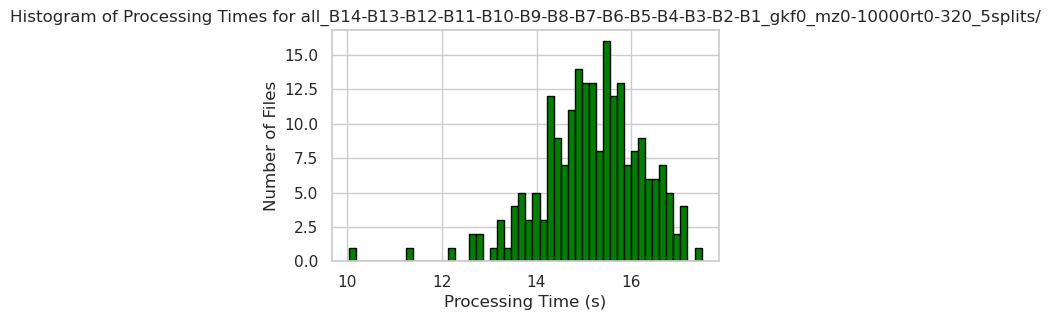

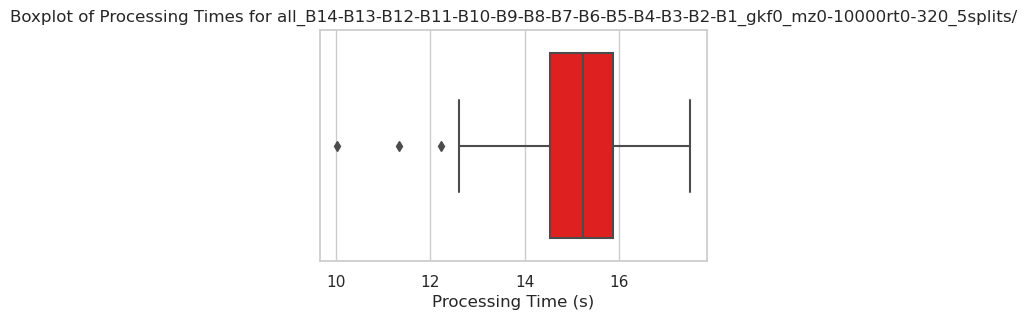

Analyzing mz10 gkf1
Total processing time: 7855.93 s
Average processing time: 36.54 s
Largest processing time: 69.84 (69.84 s)
Smallest processing time: 21.77 (21.77 s)


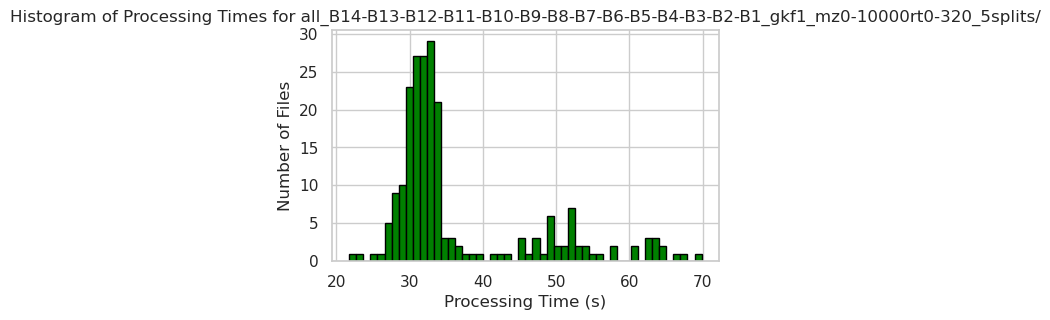

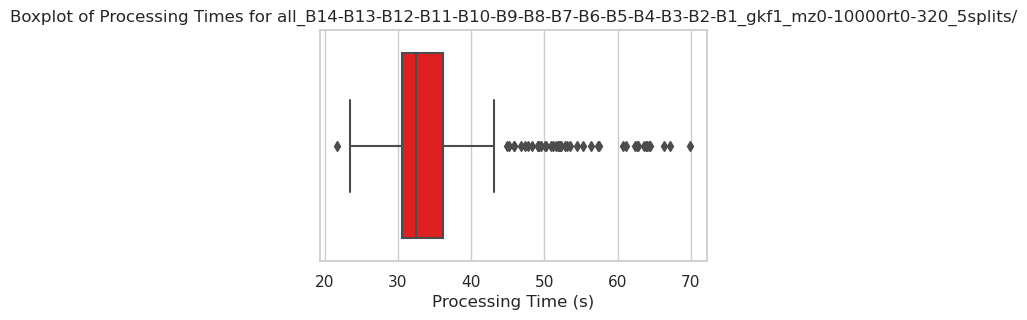

,mz,gkf,time
0,1,0,62.33
1,1,0,146.16
2,1,0,137.87
3,1,0,125.90
4,1,0,157.90
...,...,...,...
210,10,1,33.54
211,10,1,28.08
212,10,1,33.17
213,10,1,34.94


In [15]:
# prepare a df to store the processing times to plot boxplots.
# columns: mz, gkf, time
df = pd.DataFrame()

for mz in [1, 2, 5, 10]:
    for gkf in [0, 1]:
        print(f'Analyzing mz{mz} gkf{gkf}')
        directory_path = f'/home/simon/MSML3/resources/bacteries_2024/matrices/mz{mz}/rt10/mzp{mz}/rtp10/thr0.0/200spd/ms2/combat0/shift0/none/loginloop/none'
        file_types = f'all_B14-B13-B12-B11-B10-B9-B8-B7-B6-B5-B4-B3-B2-B1_gkf{gkf}_mz0-10000rt0-320_5splits/'
        times = analyze_processing_time(directory_path, file_types)
        # Add the processing times to the df
        df = pd.concat([df, pd.DataFrame({'mz': [mz] * len(times), 'gkf': [gkf] * len(times), 'time': times})])

df

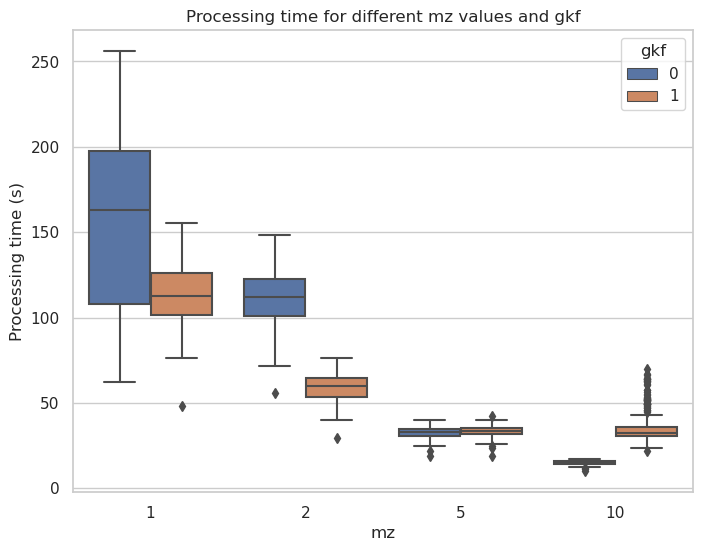

In [16]:
# plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='mz', y='time', hue='gkf')
plt.xlabel('mz')
plt.ylabel('Processing time (s)')
plt.title('Processing time for different mz values and gkf')
plt.show()

Analyzing mz1 gkf1
Total processing time: 18499.77 s
Average processing time: 132.14 s
Largest processing time: 233.271118263 (233.27 s)
Smallest processing time: 38.170678451 (38.17 s)


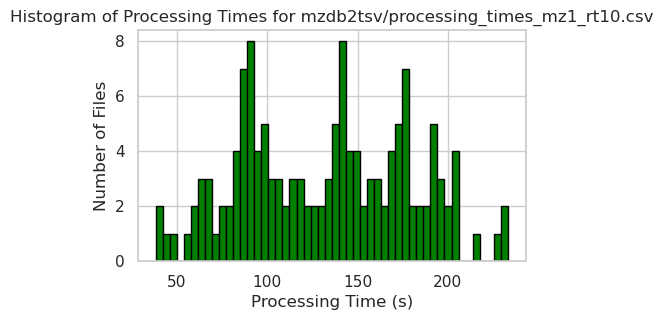

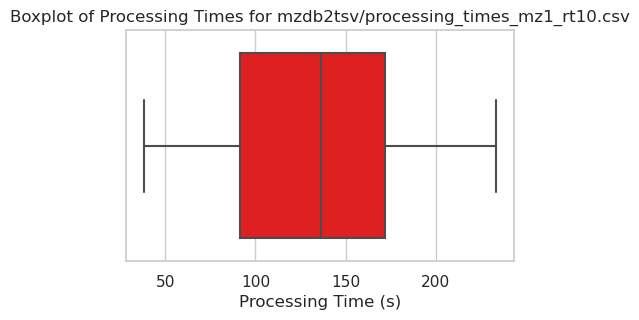

Analyzing mz2 gkf1
Total processing time: 18499.77 s
Average processing time: 132.14 s
Largest processing time: 233.271118263 (233.27 s)
Smallest processing time: 38.170678451 (38.17 s)


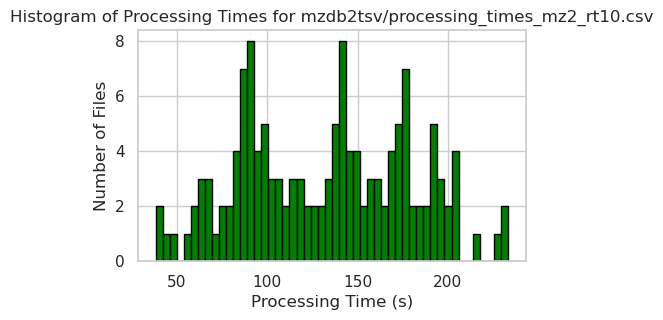

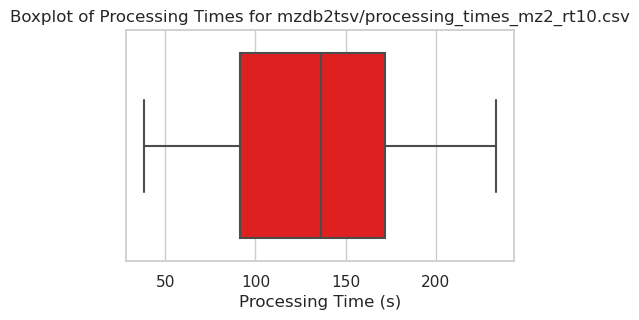

Analyzing mz5 gkf1
Total processing time: 18499.77 s
Average processing time: 132.14 s
Largest processing time: 233.271118263 (233.27 s)
Smallest processing time: 38.170678451 (38.17 s)


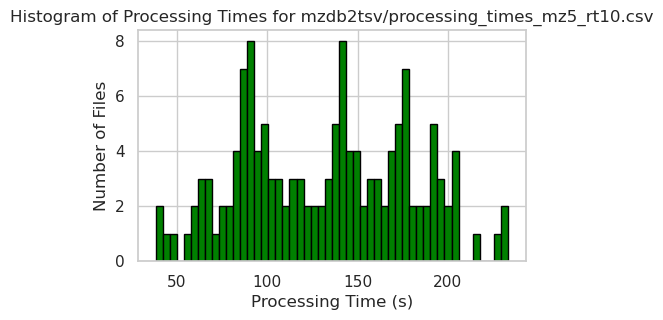

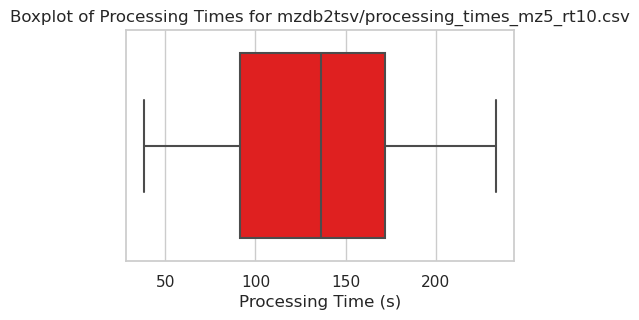

Analyzing mz10 gkf1
Total processing time: 18499.77 s
Average processing time: 132.14 s
Largest processing time: 233.271118263 (233.27 s)
Smallest processing time: 38.170678451 (38.17 s)


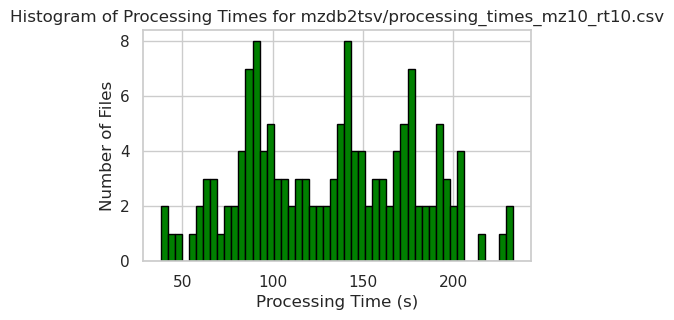

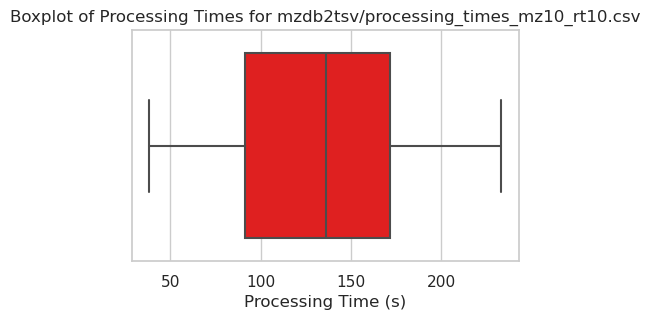

,mz,gkf,time
0,1,1,62.647812
1,1,1,64.979505
2,1,1,66.733753
3,1,1,66.921994
4,1,1,72.354710
...,...,...,...
135,10,1,150.577083
136,10,1,179.337464
137,10,1,172.080367
138,10,1,162.530922


In [18]:
# prepare a df to store the processing times to plot boxplots.
# columns: mz, gkf, time
df = pd.DataFrame()

for mz in [1, 2, 5, 10]:
    print(f'Analyzing mz{mz} gkf{gkf}')
    directory_path = f'msml/'
    file_types = f'mzdb2tsv/processing_times_mz{mz}_rt10.csv'
    times = analyze_processing_time(directory_path, file_types)
    # Add the processing times to the df
    df = pd.concat([df, pd.DataFrame({'mz': [mz] * len(times), 'gkf': [gkf] * len(times), 'time': times})])

df

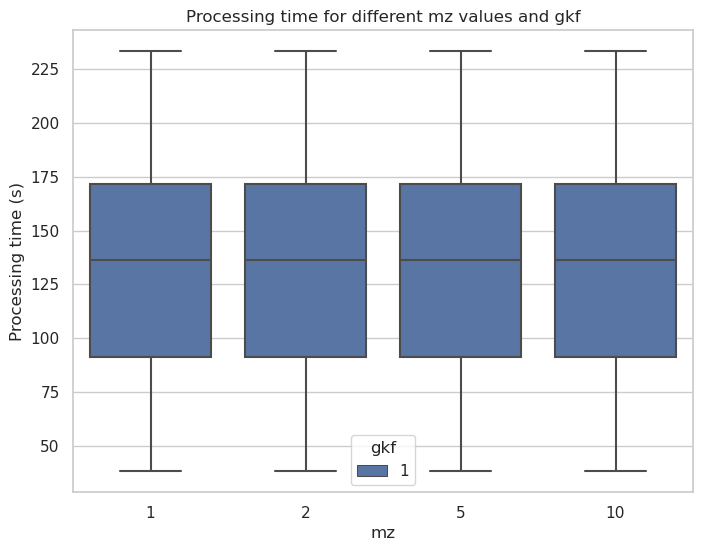

In [19]:
# plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='mz', y='time', hue='gkf')
plt.xlabel('mz')
plt.ylabel('Processing time (s)')
plt.title('Processing time for different mz values and gkf')
plt.show()